In [1]:
# Importamos las librerías que vamos a utilizar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles

Vamos a crear un modelo neural clasificatorio que sea capaz de diferenciar entre dos clases
de puntos. Para ello, utilizaremos diferentes librerías que nos ayudarán tanto a generar el
dataset como a generar y entrenar el modelo.


1. Genere una nube de puntos consistente en dos anillos concéntricos de diferente
   tamaño, de los cuales los que pertenezcan al primero serán de una clase y los del
   segundo a otra.


In [2]:
# Creamos los datos
# Vamos a tener 1000 puntos
n = 1000

# Creamos los datos de los dos anillos con el dataset
# make_circles de sklearn, vamos a crear dos anillos
# uno con la mitad de radio que el otro (factor=0.05)
# y añadimos un cierto ruido a los puntos de forma que
# no todos tienen exactamente la misma distancia al centro (noise=0.5),
# siendo noise la desviación standard
# Esto genera una lista de coordenadas de X=[x,y]  y
# en Y un vector con la clasificación de cada punto (0 o 1).
X, Y = make_circles(n_samples=n, factor=0.5, noise=0.05)


2. Visualice el dataset y diga el tamaño del tensor de puntos


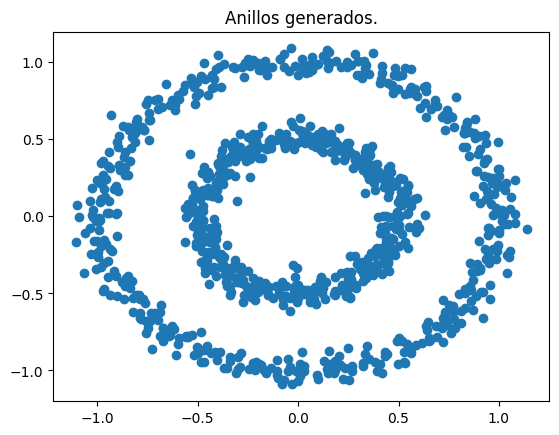

In [3]:
# Ahora vamos a visualizar el dataset, para ello vamos a utilizar
# la librería de visualización de datos matplotlib:
plt.scatter(X[:, 0], X[:, 1])
plt.title('Anillos generados.')
plt.show()


In [4]:
# Como dijimos antes, los puntos en X están guardados como un tensor de orden 2,
# Como tenemos 1000 puntos tendrá una dimensión de (1000, 2)
print('Dimensiones de X: ', X.shape)
# Por otro lado Y será un vector con los resultados, con 1000 datos:
print('Dimensiones de Y: ', Y.shape)

Dimensiones de X:  (1000, 2)
Dimensiones de Y:  (1000,)


In [5]:
# Una forma cómoda de ver un ejemplo de los datos puede ser verlos en un dataframe
# utilizando la librería pandas:
data_pd = pd.DataFrame()
data_pd['x'] = X[:, 0]
data_pd['y'] = X[:, 1]
data_pd['R'] = np.sqrt(X[:, 0]**2 + X[:, 1]**2)
data_pd['Label'] = Y

print('Vamos a mostrar los 10 primeros puntos, \n',
      'mostrando en x la coordenada x, en y la coordenada y\n',
      'en R la distancia al 0 a la que se encuentra el punto\n',
      'y en label la etiqueta.')
data_pd.head(10)


Vamos a mostrar los 10 primeros puntos, 
 mostrando en x la coordenada x, en y la coordenada y
 en R la distancia al 0 a la que se encuentra el punto
 y en label la etiqueta.


,x,y,R,Label
0,0.070329,0.946760,0.949369,0
1,0.137323,0.477915,0.497253,1
2,0.057523,0.586516,0.589330,1
3,-0.357893,-0.426859,0.557042,1
4,-0.429273,0.915958,1.011560,0
5,1.138755,-0.083396,1.141805,0
6,0.453755,-0.215561,0.502355,1
7,-0.384697,-0.244775,0.455968,1
8,-0.184338,-0.965373,0.982815,0
9,-0.196088,-0.959825,0.979650,0


Aquí podemos ver que los datos con R cercano a 1, pertenecen al círculo de fuera, y tienen como etiqueta '0' mientras que los puntos con R cercano a 0.5 pertenecen al círculo de dentro y tienen como etiqueta '1'.


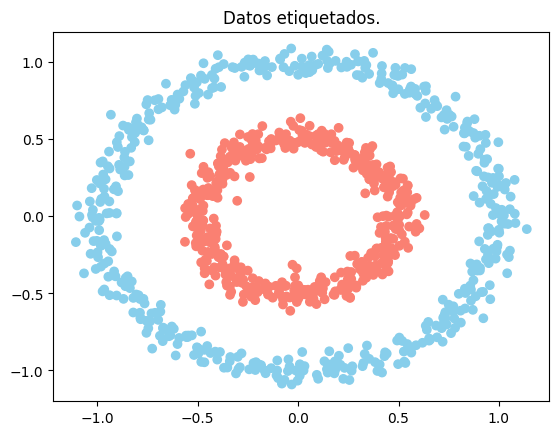

In [6]:
# Ahora vamos a aprovechar que podemos usar un mapa de color para
# Representar los puntos de cada categoría de un color diferente:

plt.scatter(X[:, 0], X[:, 1], c=['skyblue' if y == 0 else 'salmon' for y in Y])
plt.title('Datos etiquetados.')
plt.show()


3. Cree y entrene los modelos utilizando los siguientes módulos:


### a. Utilizando Pytorch


In [7]:
# Importamos las librerías necesarias para crear la red con Torch:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import relu


In [8]:
# En torch hay que crear nuestra red neuronal como una clase que hereda de nn.Module:
class RedNeuronal(nn.Module):
    # Definimos el constructor de la clase:
    def __init__(self):
        super(RedNeuronal, self).__init__()
        self.layer1 = nn.Linear(2, 4)
        self.layer2 = nn.Linear(4, 8)
        self.layer3 = nn.Linear(8, 16)
        self.layer4 = nn.Linear(16, 8)
        self.layer5 = nn.Linear(8, 4)
        self.layer6 = nn.Linear(4, 1)

    # Definimos el método de propagación hacia delante:
    def forward(self, x):
        # Vamos a utilizar capas con función de activación relu.
        # (Rectified Linear Unit)
        x = relu(self.layer1(x))
        x = relu(self.layer2(x))
        x = relu(self.layer3(x))
        x = relu(self.layer4(x))
        x = relu(self.layer5(x))
        # A la última capa de pasamos una función sigmoide
        # para que los resultados estén entre 0 y 1
        x = torch.sigmoid(self.layer6(x))
        return x

    # Definimos un método para entrenar la red.
    def train(self, X, Y, num_epochs=100, lr=0.03, print_interval=20, stop_loss=0.0015,
              optimizer=optim.Adam, criterion=nn.BCELoss()):

        optimizer = optimizer(self.parameters(), lr=lr)

        LOSS = []
        ITER = []

        for i in range(num_epochs):
            result = self(X)

            loss = criterion(result, Y)

            if i % print_interval == 0:
                LOSS.append(loss.item())
                ITER.append(i)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if loss.item() < stop_loss:
                print(f'Entrenamiento finalizado.')
                break

            if i != 0 and i % (num_epochs - 1) == 0:
                print(f'Entrenamiento finalizado en {num_epochs} epochs.')

        return LOSS, ITER

In [9]:
# Ahora vamos a pasar el modelo a la GPU de estar esta disponible para su uso.

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Usando {device}')
# Pasamos el modelo al dispositivo:
modelo = RedNeuronal().to(device)
# Mostramos el modelo.
print(modelo)

Usando cpu
RedNeuronal(
  (layer1): Linear(in_features=2, out_features=4, bias=True)
  (layer2): Linear(in_features=4, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=8, bias=True)
  (layer5): Linear(in_features=8, out_features=4, bias=True)
  (layer6): Linear(in_features=4, out_features=1, bias=True)
)


In [10]:
# Ahora vamos a crear el optimizador del modelo:
# Vamos a utilizar el descenso del gradiente estocástico,
# le pasamos los parámetros del modelo y establecemos el learning rate.
optimizer = optim.Adam
# Y definimos la función de pérdida que vamos a usar:
# Vamos a utilizar como función del pérdida la binary cross entropy.
# la cual se utiliza para problemas de clasificación binaria.
criterion = nn.BCELoss()

In [11]:
# Transformamos los datos que tenemos en numpy a tensores de torch:
# para utilizarlos en nuestro modelo.
X_t = torch.from_numpy(X).float().to(device)
Y_t = torch.from_numpy(Y).float().to(device)
# Esto es para que tenga la forma de (n, 1) para poder realizar las operaciones.
Y_t = Y_t.reshape(-1, 1)


In [12]:
# Creamos el objeto red neuronal:
modelo = RedNeuronal()

In [13]:
# Entrenamos la red neuronal usando el método train que hemos definido:
# (Se que estoy utilizando los que he puesto por defecto llamandolos, pero
# es solo con fines ilustrativos).
LOSS, ITER = modelo.train(X_t, Y_t, num_epochs=30000, optimizer=optimizer, criterion=criterion)

Entrenamiento finalizado.


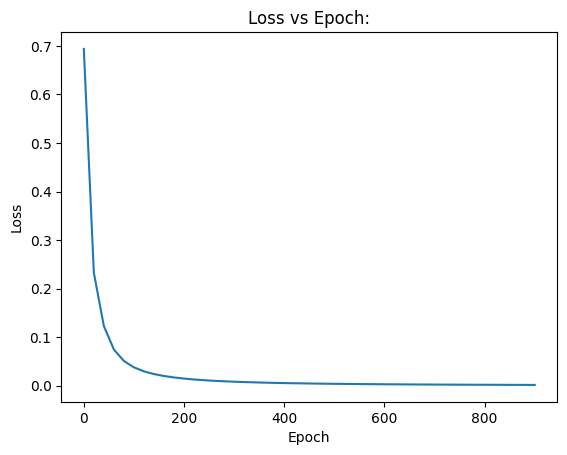

In [14]:
plt.plot(ITER,LOSS)
plt.title('Loss vs Epoch:')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

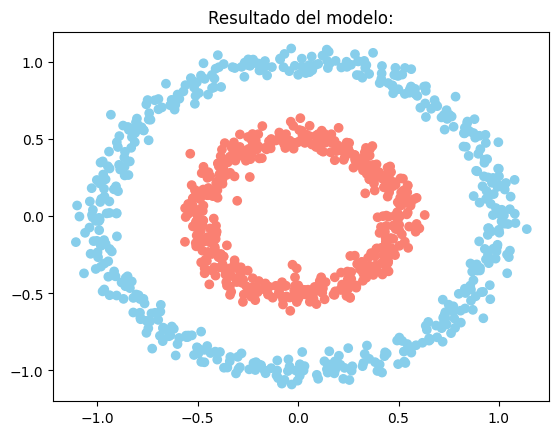

In [15]:
# Ahora vamos a mostrar los resultados:
result = modelo.forward(X_t)

# se pasa el resultado a la cpu como un array de numpy:
np_result = result.cpu().detach().numpy()

# Graficamos los resultados al igual que antes:
# Dado que en la última capa tenemos una función de activación sigmoide,
# los resultados están en el rango de 0 a 1. Los resultados inferiores a 0.5
# pertenecen a la clase '1' y los resultados mayores o iguales a 0.5 pertenecen a la clase '0'.
plt.scatter(X[:, 0], X[:, 1],
            c=['skyblue' if y < 0.5 else 'salmon' for y in np_result[:, 0]])
plt.title('Resultado del modelo:')
plt.show()


# Nota: podemos mejorar el método de entrenamiento de forma que en cada época muestre los resultados de una parte de los puntos que se utilizan para validación.


# Vamos a meter esto en el método de entrenamiento para que también nos devuelva la accuracy:

# PODEMOS TAMBIÉN AÑADIR LA FORMA INTERACTIVA DE VER COMO AVANZA EL MAPA DE PREDICCIONES PONIENDO A PREDECIR UNA MALLA DE PUNTOS.

In [16]:
pred =[0 if y < 0.5 else 1 for y in np_result[:, 0]]

In [17]:

vector = pred == Y
vector = [0 if y == True else 0 for y in vector]
acc = 1-np.mean(vector)
print(acc)

1.0


## b. Utilizando Tensorflow y Keras

In [18]:
# Importamos las librerías que vamos a utilizar:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

In [19]:
model = Sequential([
    tf.keras.layers.Dense(4, input_shape=(2,), activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer = 'Adam', loss = 'BinaryCrossentropy', metrics='accuracy')

In [20]:
model.fit(X, Y, epochs=100, batch_size=32)

Epoch 1/100
32/32 [==============================] - 1s 760us/step - loss: 0.6893 - accuracy: 0.5060
Epoch 2/100
32/32 [==============================] - 0s 737us/step - loss: 0.6847 - accuracy: 0.5080
Epoch 3/100
32/32 [==============================] - 0s 744us/step - loss: 0.6756 - accuracy: 0.5230
Epoch 4/100
32/32 [==============================] - 0s 751us/step - loss: 0.6589 - accuracy: 0.5320
Epoch 5/100
32/32 [==============================] - 0s 769us/step - loss: 0.6313 - accuracy: 0.5580
Epoch 6/100
32/32 [==============================] - 0s 754us/step - loss: 0.5890 - accuracy: 0.6390
Epoch 7/100
32/32 [==============================] - 0s 753us/step - loss: 0.5423 - accuracy: 0.7080
Epoch 8/100
32/32 [==============================] - 0s 759us/step - loss: 0.4979 - accuracy: 0.7830
Epoch 9/100
32/32 [==============================] - 0s 748us/step - loss: 0.4651 - accuracy: 0.8180
Epoch 10/100
32/32 [==============================] - 0s 781us/step - loss: 0.4408 - accura

32/32 [==============================] - 0s 603us/step


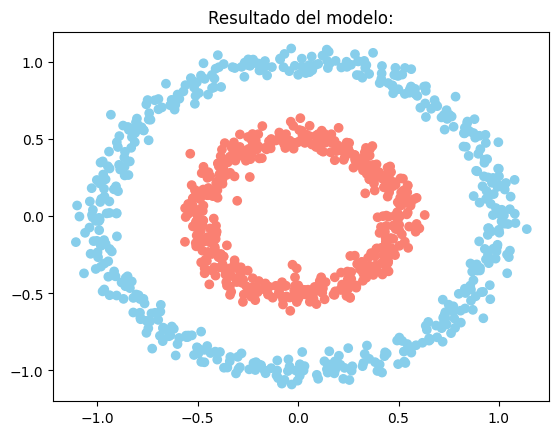

In [21]:
result = model.predict(X)

plt.scatter(X[:, 0], X[:, 1],
            c=['skyblue' if y < 0.5 else 'salmon' for y in result])
plt.title('Resultado del modelo:')
plt.show()

# Me ha dado pereza todavía pero hay que poner comentarios a todo lo que hemos hecho

## c. Utilizando Scikit-Learn

In [22]:
# Importamos las librerías necesarias: 
import sklearn as sk
from sklearn.neural_network import MLPRegressor


In [29]:
# Creamos el modelo:
skmodel = MLPRegressor(hidden_layer_sizes=[4,8,4],
                       activation='relu',
                       solver='adam',
                       learning_rate_init=0.03,
                       verbose=True,
                       max_iter=1000)

In [30]:
# Entrenamos al modelo:
model.fit(X, Y)

32/32 [==============================] - 0s 871us/step - loss: 0.0410 - accuracy: 1.0000


32/32 [==============================] - 0s 581us/step


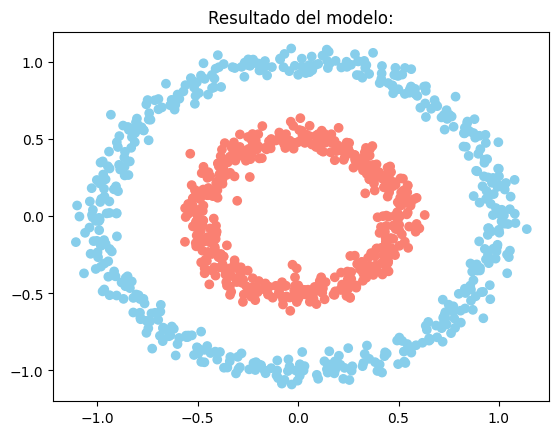

In [31]:
result = model.predict(X)

plt.scatter(X[:, 0], X[:, 1],
            c=['skyblue' if y < 0.5 else 'salmon' for y in result])
plt.title('Resultado del modelo:')
plt.show()

## 4. Compare los resultados obtenidos de cada modelo